In [1]:
import matplotlib.pyplot as plt
import numpy as np

# working with images
import os
import PIL # python library for images
import pathlib

import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, losses, metrics, utils


> NOTE: It's recommended to use GPU for the best performance (speed).

## 1. Download The Flowers Image Data

In [2]:
images_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

#download the data from the drive link
data_dir = utils.get_file('flower_photos',
                          origin=images_url,
                          untar=True) # uncompress the .tgz file

data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
# get the images based on jpg extension
list(data_dir.glob('*/*.jpg'))

[PosixPath('/root/.keras/datasets/flower_photos/roses/2065522422_cfdd80044a_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/1392579828_ab5a139052.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/15060816740_68e1b2c31b.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/4588034197_e300b0872a_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/22093190909_77223e6f53_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/20596941736_f2c5f496cf.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/9633056561_6f1b7e8faf_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/7345657862_689366e79a.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/15104537437_f6730b38c3_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/6864417932_36fa4ceecf_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/17302463621_d82be11f01_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/7186509956_c37

In [4]:
# grab all the images that are roses
roses_images = list(data_dir.glob('roses/*'))

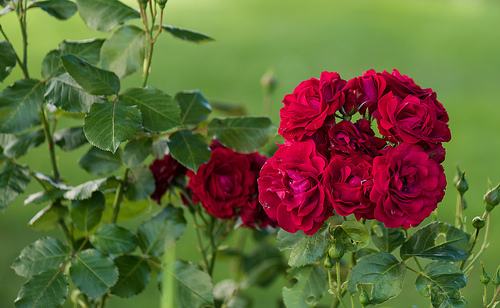

In [5]:
# display the 6th image on the list
PIL.Image.open(roses_images[5])

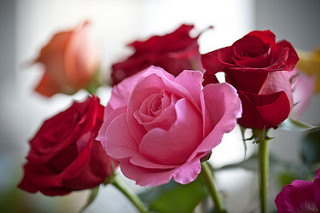

In [6]:
PIL.Image.open(roses_images[11])

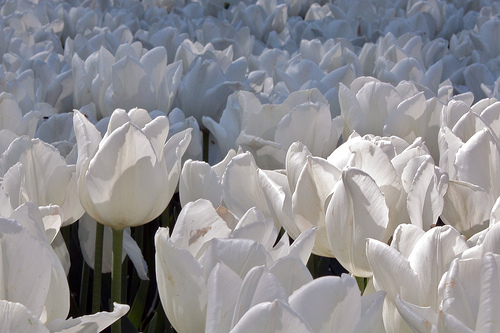

In [7]:
tulips_images = list(data_dir.glob('tulips/*'))
PIL.Image.open(tulips_images[13])

## 2. Split The Data Into Train and Validation Subsets

Since we're dealing with a directory of images, we need to use `image_dataset_from_directory` utility from `keras` to split the data into train and validation

In [8]:
# data ingestion hyperparameters

val_split = 0.2
# for consistency, we need to have a unified image size
img_h, img_w = 180, 180
batch_sz = 32
seed_val = 100 # represents the random_state from sklearn


### Training Data

In [9]:
training_data = utils.image_dataset_from_directory( directory=data_dir,
                                                   validation_split=val_split,
                                                    subset='training',
                                                    seed=seed_val,
                                                    image_size=(img_h, img_w),
                                                    batch_size=batch_sz
                                                    )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
3670*.8

2936.0

Log above shows that we have 5 classes (flower types) and it picked up 2936 images, which is 80% of the main dataset.

In [11]:
testing_data = utils.image_dataset_from_directory( directory=data_dir,
                                                   validation_split=val_split,
                                                    subset='validation',
                                                    seed=seed_val,
                                                    image_size=(img_h, img_w),
                                                    batch_size=batch_sz
                                                    )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 3. Display The Classes and Visualize A Sample

In [12]:
flower_classes = training_data.class_names
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
training_data.take(1) # tensor of the images that can be used to drive the for loop

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

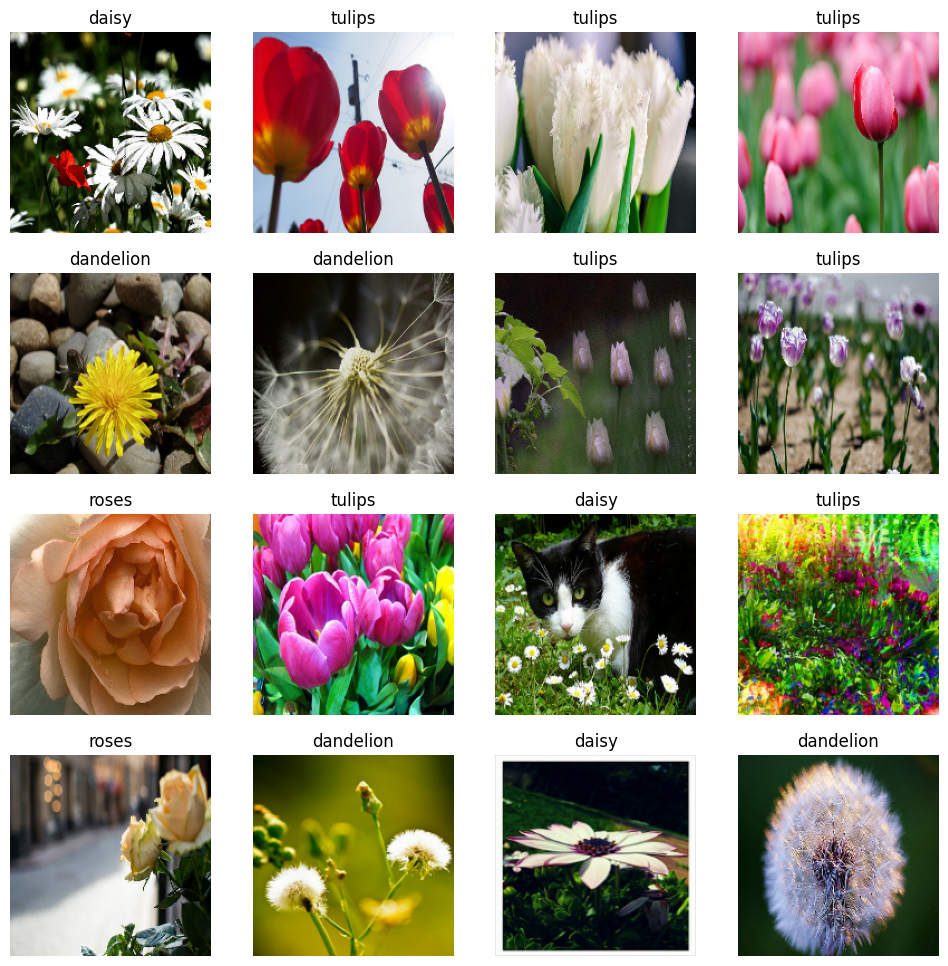

In [14]:
plt.figure(figsize=(12,12))

for img, lbl in training_data.take(1):
  # loop throug 16 images (for 4x4 grid)
  for idx in range(16):
    plt.subplot(4,4,idx+1)
    # convert image tensor into a numpy readable format for matplotlib
    img_conv = img[idx].numpy().astype('uint8')
    plt.imshow(img_conv)
    plt.axis('off')
    #add the label at the top
    plt.title(flower_classes[lbl[idx]])

## 4. Preprocessing, Normalization, and Performance Optimization Using `keras`

 -  Performance Optimization
  1. Use `AUTOTUNE` util to allow the input pipeline to automatically tune the numer of parallel processes for best performance
  2. Use `cache` for memory optimization
  3. Use `shuffle` to ensure a fair distribution of the images

- Normalization
 - Use `Rescaling` layer

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
# apply performance optimization on the data
training_data = training_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.prefetch(buffer_size=AUTOTUNE) # only prefetch is needed since cache and shuffle are for training performance


In [16]:
# normalization attributes
img_norm = layers.Rescaling(1.0/255.0)

#to see the applied normalization
#normalized_data = training_data.map(lambda x, y: (normalization_layer(x), y))

## 5. Apply Image Augmentation

In [17]:
img_aug = models.Sequential([

                      layers.RandomFlip('horizontal'),
                      layers.RandomRotation(0.12),
                      layers.RandomZoom(0.07),
                      layers.RandomBrightness(.3)
                      ])

## 6. Build The NN Model

In [18]:
cnn_model = models.Sequential([ layers.Input(shape=(img_h, img_w, 3)),
                                img_aug,
                                img_norm,
                                # a popular architecture is to start witha. low num 32 and double it as you add more convolutions
                                # Conv Block 1
                                layers.Conv2D(32, kernel_size=3
                                              , padding='same' # enabling padding
                                              , activation='relu'),
                                layers.MaxPool2D(), # if you don't mention the pooling size, it picks 2x2 by default

                                # Conv Block 2
                                layers.Conv2D(64, kernel_size=3
                                            , padding='same'
                                            , activation='relu'),
                                layers.MaxPool2D(),

                                # Conv Block 3
                                layers.Conv2D(128, kernel_size=3
                                            , padding='same'
                                            #, activation='relu'
                                            ),
                                layers.LeakyReLU(alpha=0.05), # applied as a layer vs text value in 'relu'
                                layers.MaxPool2D(),
                                # minimal regularization
                               layers.Dropout(0.05),

                               # fully connected layer
                                layers.Flatten(),
                                layers.Dense(128, activation='relu'), #hidden layer 1
                                layers.Dense(64, activation='relu'),  #hidden layer 2
                                layers.Dense(5) #output layer - no activation funciton used - consider using it in the future to make prediction readable
                        ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [19]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,031,813 (30.64 MB)

 Trainable params: 8,031,813 (30.64 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

cnn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

## 7. Start Training

In [21]:
ep=18
model_hist = cnn_model.fit(training_data, validation_data=testing_data, epochs=ep)

Epoch 1/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.3845 - loss: 1.4454 - val_accuracy: 0.5899 - val_loss: 1.0546
Epoch 2/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.5230 - loss: 1.1064 - val_accuracy: 0.6035 - val_loss: 1.0062
Epoch 3/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6236 - loss: 0.9286 - val_accuracy: 0.6471 - val_loss: 0.9173
Epoch 4/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6415 - loss: 0.8888 - val_accuracy: 0.6812 - val_loss: 0.8279
Epoch 5/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.6702 - loss: 0.8551 - val_accuracy: 0.6676 - val_loss: 0.8775
Epoch 6/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6899 - loss: 0.7932 - val_accuracy: 0.7030 - val_loss: 0.7891
Epoch 7/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7247 - loss: 0.7109 - val_accuracy: 0.7180 - val_loss: 0.7501
Epoch 8/18
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7361 - loss: 0.6902 - val_accuracy: 0.7084 

In [32]:
model_hist.history

{'accuracy': [0.4523160755634308,
  0.5507493019104004,
  0.6212534308433533,
  0.649523138999939,
  0.6726838946342468,
  0.6883515119552612,
  0.7220708727836609,
  0.7247956395149231,
  0.738760232925415,
  0.7534059882164001,
  0.7506812214851379,
  0.7605586051940918,
  0.7816757559776306,
  0.7905313372612,
  0.8027929067611694,
  0.8126702904701233,
  0.8106266856193542,
  0.8133515119552612],
 'loss': [1.2959766387939453,
  1.0711263418197632,
  0.9367250800132751,
  0.8726984858512878,
  0.8474518656730652,
  0.7925257086753845,
  0.7359028458595276,
  0.7054399847984314,
  0.6826727390289307,
  0.6458386182785034,
  0.6459553241729736,
  0.5951929092407227,
  0.5918077826499939,
  0.5684404969215393,
  0.5252412557601929,
  0.4859495759010315,
  0.48682138323783875,
  0.48620980978012085],
 'val_accuracy': [0.5899182558059692,
  0.6035422086715698,
  0.6471389532089233,
  0.6811988949775696,
  0.667574942111969,
  0.7029972672462463,
  0.7179836630821228,
  0.7084468603134155

## 8. Evaluation

In [33]:
plt.style.use('ggplot')

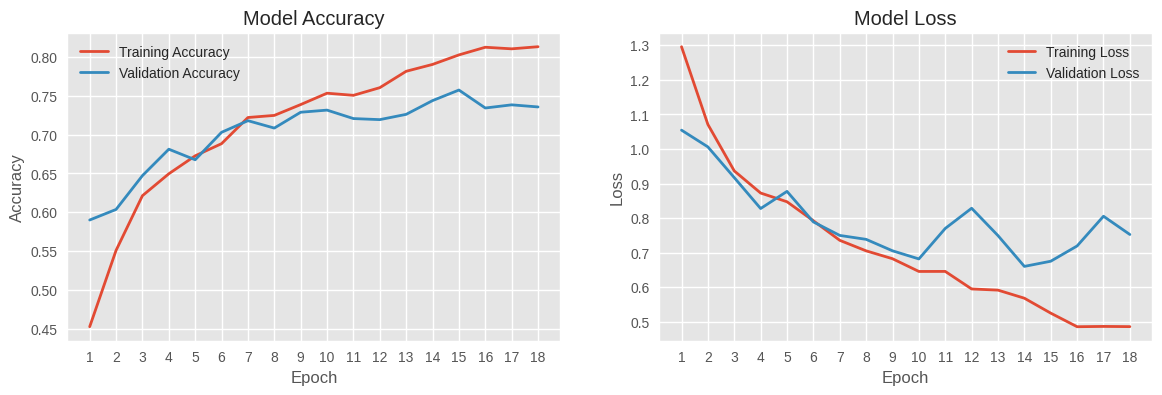

In [39]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(14,4))

#accuracy plot
plt1.plot(model_hist.history['accuracy'], label='Training Accuracy', linewidth=2)
plt1.plot(model_hist.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt1.set_title('Model Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_xticks(range(ep))
plt1.set_xticklabels(range(1,ep+1))
plt1.legend()

#loss plot
plt2.plot(model_hist.history['loss'], label='Training Loss', linewidth=2)
plt2.plot(model_hist.history['val_loss'], label='Validation Loss', linewidth=2)
plt2.set_title('Model Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_xticks(range(ep))
plt2.set_xticklabels(range(1,ep+1))
plt2.legend()

**observation** Looks like Epoch = 15 is the best trad-off between overfitting and underfitting.

## 8. Using The Model To Predict

In [40]:
sunflower_img_url = 'https://www.peachtreepetals.com/cdn/shop/articles/all_about_sunflowers.jpg?v=1631036676&width=1600'

sunflower_img_path = utils.get_file('sunflower', origin=sunflower_img_url)

261323/261323 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Before sending the image to the model for prediction, convert to expeccted dimensions.

In [42]:
# image copatiblity steps
sunflower_img = utils.load_img(sunflower_img_path, target_size=(img_h, img_w))
sunflower_img_array = utils.img_to_array(sunflower_img)
sunflower_img_array = tf.expand_dims(sunflower_img_array, 0)

In [43]:
sunflower_prediction = cnn_model.predict(sunflower_img_array)
sunflower_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[-8.420086 , -2.6444945, -2.0134559,  6.1833344,  2.1741896]],
      dtype=float32)

- The output has 5 numbers (a value for each class) we have 5 classes
- Since we did not speicify an activation funciton at the output, we need to add one to make the final output readable
- `softmax` should be used for multi-classes (sigmoid for binary)

In [44]:
sunflower_prediction_final = tf.nn.softmax(sunflower_prediction[0]) #using 0 for a single image
sunflower_prediction_final

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([4.4650227e-07, 1.4392323e-04, 2.7051260e-04, 9.8176712e-01,
       1.7818004e-02], dtype=float32)>

In [50]:
print(f'Model Prediction:{flower_classes[np.argmax(sunflower_prediction_final)]} with a {np.max(sunflower_prediction_final)*100:.2f}% confidence')

Model Prediction:sunflowers with a 98.18% confidence
